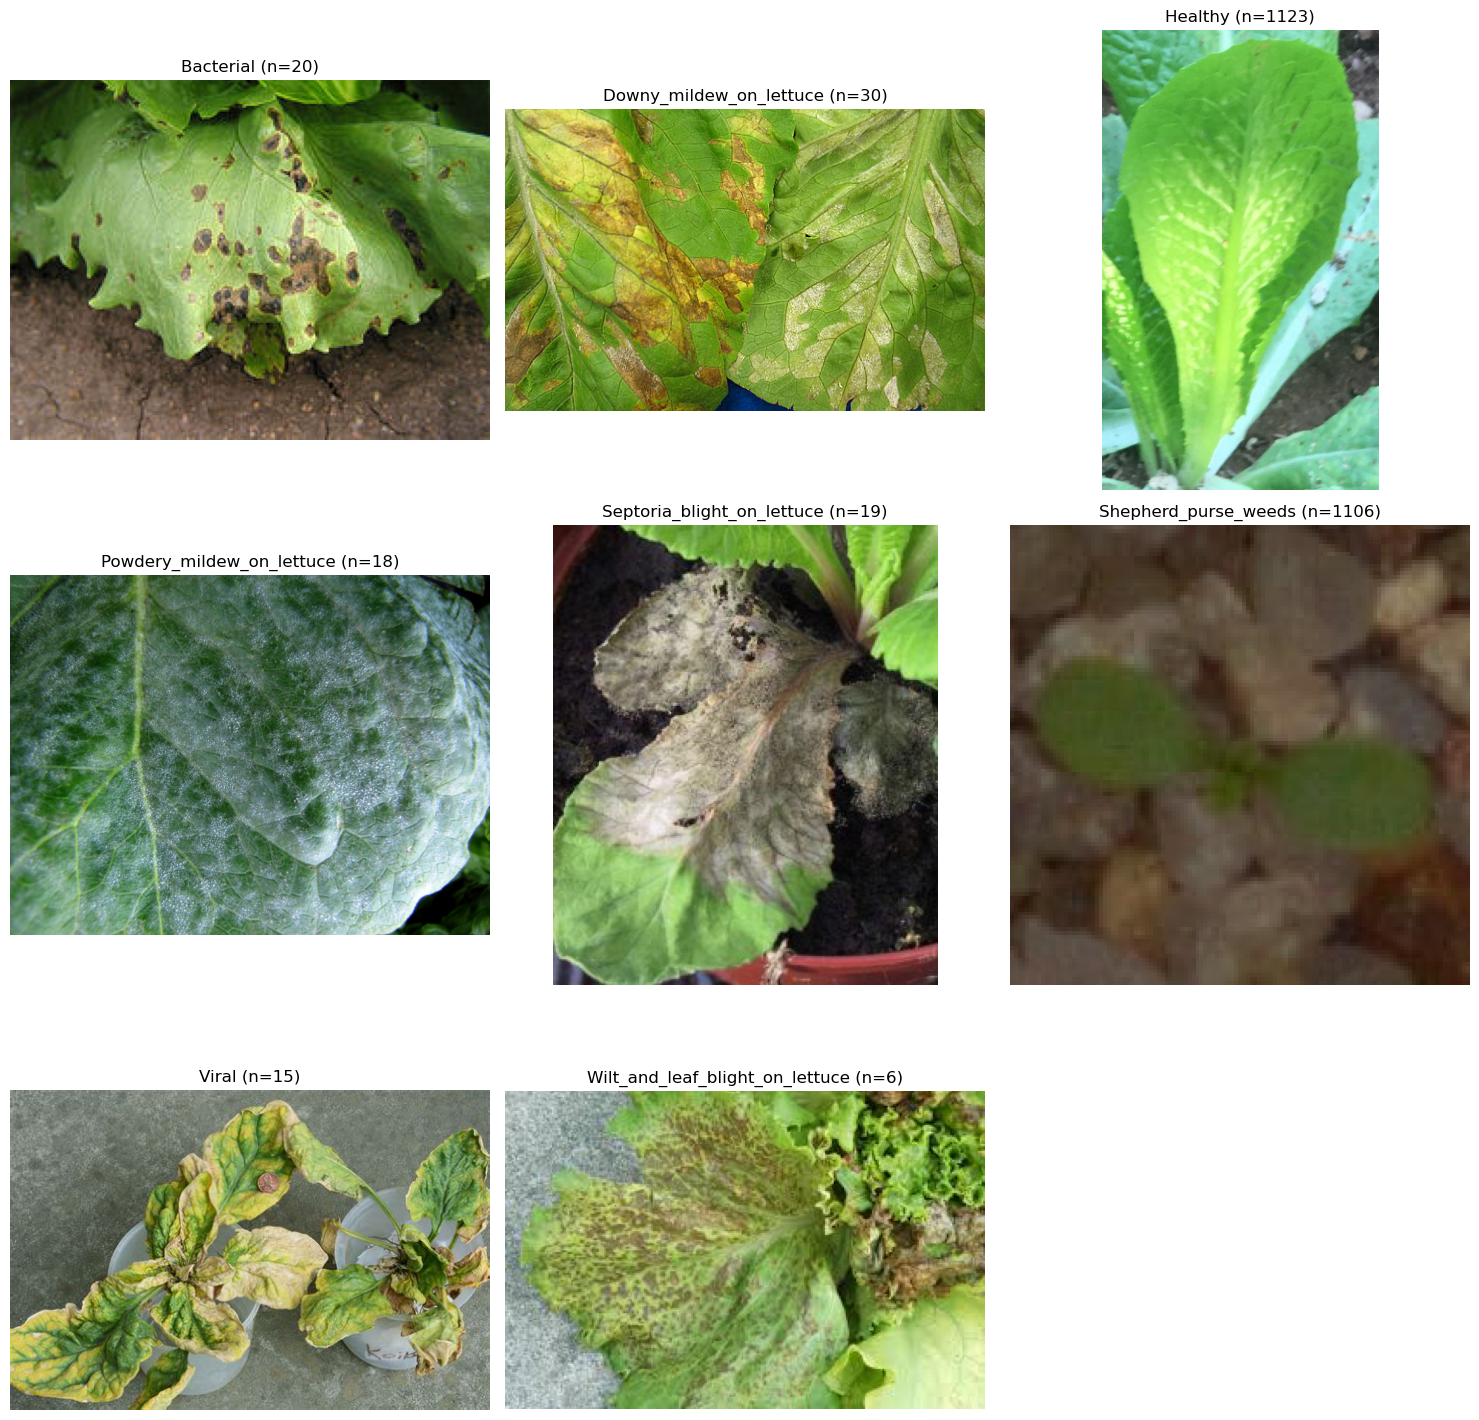

Class Distribution:
Bacterial: 20 images
Downy_mildew_on_lettuce: 30 images
Healthy: 1123 images
Powdery_mildew_on_lettuce: 18 images
Septoria_blight_on_lettuce: 19 images
Shepherd_purse_weeds: 1106 images
Viral: 15 images
Wilt_and_leaf_blight_on_lettuce: 6 images


In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

dataset_path = r"C:\Users\gky16\Downloads\Lettuce_disease_datasets"
classes = os.listdir(dataset_path)
n_classes = len(classes)

# Create appropriate grid
n_cols = min(3, n_classes)  # Max 3 columns
n_rows = (n_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

# Handle single subplot case
if n_classes == 1:
    axes = [axes]
elif n_rows > 1:
    axes = axes.flatten()

class_counts = {}
for i, cls in enumerate(classes):
    class_path = os.path.join(dataset_path, cls)
    class_counts[cls] = len(os.listdir(class_path))
    
    img_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = Image.open(img_path)
    
    axes[i].imshow(img)
    axes[i].set_title(f"{cls} (n={class_counts[cls]})", fontsize=12)
    axes[i].axis('off')

# Hide extra subplots if any
for i in range(n_classes, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Print class distribution
print("Class Distribution:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
import cv2
import os

def extract_features(image_path):
    """Extract HOG and LBP features from image"""
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # HOG features
    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys')
    
    # LBP features
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype('float') / lbp_hist.sum()
    
    return np.concatenate([hog_features, lbp_hist])

# Load and preprocess data
X, y = [], []
dataset_path = r"C:\Users\gky16\Downloads\Lettuce_disease_datasets"
classes = os.listdir(dataset_path)

for label, cls in enumerate(classes):
    class_path = os.path.join(dataset_path, cls)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        features = extract_features(img_path)
        if features is not None:
            X.append(features)
            y.append(label)

X, y = np.array(X), np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train models
models = {
    'SVM': SVC(kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    
    # FIXED: Handle class mismatch
    unique_labels = np.unique(np.concatenate((y_test, y_pred)))
    print(classification_report(y_test, y_pred, 
                               labels=unique_labels, 
                               target_names=[classes[i] for i in unique_labels]))

SVM Accuracy: 0.8568
                                 precision    recall  f1-score   support

                      Bacterial       0.00      0.00      0.00         4
        Downy_mildew_on_lettuce       0.00      0.00      0.00         6
                        Healthy       0.84      0.90      0.87       225
      Powdery_mildew_on_lettuce       0.00      0.00      0.00         4
     Septoria_blight_on_lettuce       0.00      0.00      0.00         4
           Shepherd_purse_weeds       0.88      0.90      0.89       221
                          Viral       0.00      0.00      0.00         3
Wilt_and_leaf_blight_on_lettuce       0.00      0.00      0.00         1

                       accuracy                           0.86       468
                      macro avg       0.21      0.22      0.22       468
                   weighted avg       0.82      0.86      0.84       468



C:\Users\gky16\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gky16\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gky16\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Accuracy: 0.8269
                                 precision    recall  f1-score   support

                      Bacterial       1.00      0.50      0.67         4
        Downy_mildew_on_lettuce       0.00      0.00      0.00         6
                        Healthy       0.84      0.86      0.85       225
      Powdery_mildew_on_lettuce       0.00      0.00      0.00         4
     Septoria_blight_on_lettuce       0.00      0.00      0.00         4
           Shepherd_purse_weeds       0.82      0.86      0.84       221
                          Viral       0.00      0.00      0.00         3
Wilt_and_leaf_blight_on_lettuce       0.00      0.00      0.00         1

                       accuracy                           0.83       468
                      macro avg       0.33      0.28      0.29       468
                   weighted avg       0.80      0.83      0.81       468



C:\Users\gky16\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gky16\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\gky16\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Dataset found at: C:\Users\gky16\Downloads\Lettuce_disease_datasets
Classes found: ['Bacterial', 'Downy_mildew_on_lettuce', 'Healthy', 'Powdery_mildew_on_lettuce', 'Septoria_blight_on_lettuce', 'Shepherd_purse_weeds', 'Viral', 'Wilt_and_leaf_blight_on_lettuce']
Found 1872 images belonging to 8 classes.
Found 465 images belonging to 8 classes.
Training samples: 1872
Validation samples: 465
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


C:\Users\gky16\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.4360 - loss: 1.1479 - val_accuracy: 0.4817 - val_loss: 0.9298 - learning_rate: 0.0010
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.4926 - loss: 0.9470 - val_accuracy: 0.4753 - val_loss: 0.9166 - learning_rate: 0.0010
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.4802 - loss: 0.9789 - val_accuracy: 0.4817 - val_loss: 0.9140 - learning_rate: 0.0010
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.4886 - loss: 0.9598 - val_accuracy: 0.4817 - val_loss: 0.9157 - learning_rate: 0.0010
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.5114 - loss: 0.9590 - val_accuracy: 0.4817 - val_loss: 0.9156 - learning_rate: 0.0010
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.4817 - loss: 0.9505 - val_accuracy: 0.4817 - val_loss: 0.9157 - learning_rate: 2.0000e-04
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5032 - loss: 0.8757
Test Accuracy: 0.

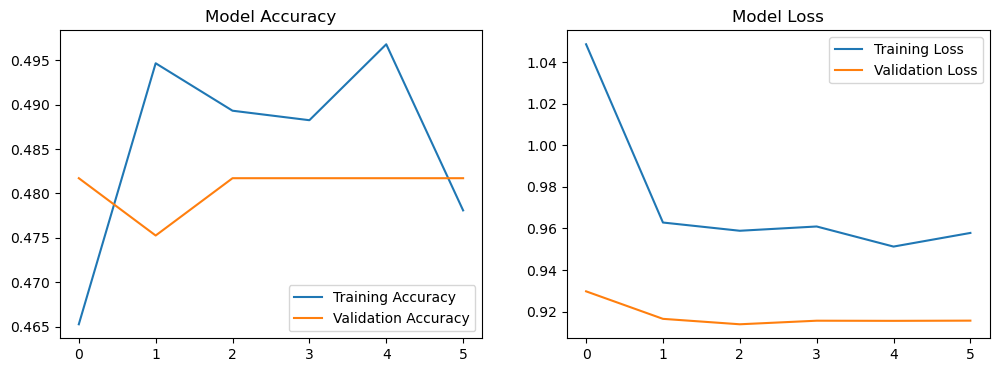

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

# Use your actual dataset path
dataset_path = r"C:\Users\gky16\Downloads\Lettuce_disease_datasets"

# Check if path exists
if not os.path.exists(dataset_path):
    print(f"Error: Path '{dataset_path}' does not exist!")
    print("Please check the path and try again.")
else:
    print(f"Dataset found at: {dataset_path}")
    classes = os.listdir(dataset_path)
    print(f"Classes found: {classes}")

# Data generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path,  # Use your actual path here
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,  # Use your actual path here
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")

# Build model
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    ]
)

# Evaluate
test_loss, test_acc = model.evaluate(val_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [ ]:
# deep_learning_approach
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import pandas as pd

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Dataset path
dataset_path = r"C:\Users\gky16\Downloads\Lettuce_disease_datasets"

# Check dataset structure
print(" Checking dataset structure...")
if os.path.exists(dataset_path):
    classes = os.listdir(dataset_path)
    print(f" Found {len(classes)} classes: {classes}")
    
    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"   {cls}: {len(images)} images")
else:
    print(" Dataset path not found!")
    exit()

# Data Augmentation and Preprocessing
print("\n Setting up data generators...")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
img_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

print(f" Training samples: {train_generator.samples}")
print(f" Validation samples: {val_generator.samples}")
print(f" Classes: {list(train_generator.class_indices.keys())}")

# Build CNN Model
print("\n Building CNN Model...")

def create_cnn_model(num_classes):
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        
        # Flatten and Dense Layers
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
num_classes = len(train_generator.class_indices)
model = create_cnn_model(num_classes)

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print(" Model architecture:")
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
]

# Train model
print("\n Training model...")
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

# Evaluate model
print("\n Evaluating model...")
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(val_generator)
print(f" Test Accuracy: {test_accuracy:.4f}")
print(f" Test Precision: {test_precision:.4f}")
print(f" Test Recall: {test_recall:.4f}")

# Predictions for confusion matrix
print("\n Generating predictions...")
val_generator.reset()
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Classification report
class_names = list(train_generator.class_indices.keys())
print("\n Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Confusion Matrix
print("\n Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Training History Visualization
print("\n Plotting training history...")
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Sample predictions visualization
print("\n Visualizing sample predictions...")
val_generator.reset()
batch = next(val_generator)
images, labels = batch
predictions = model.predict(images)

plt.figure(figsize=(15, 10))
for i in range(min(9, len(images))):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    true_class = class_names[np.argmax(labels[i])]
    pred_class = class_names[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    
    color = 'green' if true_class == pred_class else 'red'
    plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}', 
              color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Save final report
print("\n Saving final report...")
report_data = {
    'Model': ['Custom CNN'],
    'Test Accuracy': [f'{test_accuracy:.4f}'],
    'Test Precision': [f'{test_precision:.4f}'],
    'Test Recall': [f'{test_recall:.4f}'],
    'Total Parameters': [f'{model.count_params():,}'],
    'Training Samples': [train_generator.samples],
    'Validation Samples': [val_generator.samples]
}

report_df = pd.DataFrame(report_data)
print("\n Final Report:")
print(report_df.to_string(index=False))

# Save model
model.save('lettuce_disease_cnn_model.h5')
print(" Model saved as 'lettuce_disease_cnn_model.h5'")

print("\n Deep Learning Approach Completed Successfully!")

 Checking dataset structure...
 Found 8 classes: ['Bacterial', 'Downy_mildew_on_lettuce', 'Healthy', 'Powdery_mildew_on_lettuce', 'Septoria_blight_on_lettuce', 'Shepherd_purse_weeds', 'Viral', 'Wilt_and_leaf_blight_on_lettuce']
   Bacterial: 20 images
   Downy_mildew_on_lettuce: 30 images
   Healthy: 1123 images
   Powdery_mildew_on_lettuce: 18 images
   Septoria_blight_on_lettuce: 19 images
   Shepherd_purse_weeds: 1106 images
   Viral: 15 images
   Wilt_and_leaf_blight_on_lettuce: 6 images

 Setting up data generators...
Found 1872 images belonging to 8 classes.
Found 465 images belonging to 8 classes.
 Training samples: 1872
 Validation samples: 465
 Classes: ['Bacterial', 'Downy_mildew_on_lettuce', 'Healthy', 'Powdery_mildew_on_lettuce', 'Septoria_blight_on_lettuce', 'Shepherd_purse_weeds', 'Viral', 'Wilt_and_leaf_blight_on_lettuce']

 Building CNN Model...


C:\Users\gky16\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 657,352 (2.51 MB)

 Trainable params: 655,368 (2.50 MB)

 Non-trainable params: 1,984 (7.75 KB)


 Training model...


C:\Users\gky16\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8246 - loss: 0.6321 - precision: 0.8920 - recall: 0.7867
Epoch 1: val_loss improved from inf to 1.10904, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 330s 6s/step - accuracy: 0.8260 - loss: 0.6281 - precision: 0.8928 - recall: 0.7884 - val_accuracy: 0.6323 - val_loss: 1.1090 - val_precision: 0.9439 - val_recall: 0.3978 - learning_rate: 0.0010
Epoch 2/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9361 - loss: 0.2892 - precision: 0.9527 - recall: 0.9221
Epoch 2: val_loss improved from 1.10904 to 1.03574, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 331s 6s/step - accuracy: 0.9361 - loss: 0.2891 - precision: 0.9526 - recall: 0.9221 - val_accuracy: 0.5398 - val_loss: 1.0357 - val_precision: 0.6667 - val_recall: 0.4817 - learning_rate: 0.0010
Epoch 3/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9441 - loss: 0.2164 - precision: 0.9685 - recall: 0.9371
Epoch 3: val_loss improved from 1.03574 to 0.45015, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 319s 5s/step - accuracy: 0.9441 - loss: 0.2167 - precision: 0.9685 - recall: 0.9371 - val_accuracy: 0.8882 - val_loss: 0.4501 - val_precision: 0.9267 - val_recall: 0.8430 - learning_rate: 0.0010
Epoch 4/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9375 - loss: 0.2511 - precision: 0.9590 - recall: 0.9307
Epoch 4: val_loss did not improve from 0.45015
59/59 ━━━━━━━━━━━━━━━━━━━━ 273s 5s/step - accuracy: 0.9377 - loss: 0.2507 - precision: 0.9591 - recall: 0.9308 - val_accuracy: 0.7161 - val_loss: 0.9841 - val_precision: 0.7313 - val_recall: 0.7140 - learning_rate: 0.0010
Epoch 5/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9500 - loss: 0.2102 - precision: 0.9673 - recall: 0.9387
Epoch 5: val_loss improved from 0.45015 to 0.36622, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.9499 - loss: 0.2102 - precision: 0.9673 - recall: 0.9387 - val_accuracy: 0.9204 - val_loss: 0.3662 - val_precision: 0.9396 - val_recall: 0.9032 - learning_rate: 0.0010
Epoch 6/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9524 - loss: 0.1870 - precision: 0.9706 - recall: 0.9444
Epoch 6: val_loss did not improve from 0.36622
59/59 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.9524 - loss: 0.1872 - precision: 0.9706 - recall: 0.9444 - val_accuracy: 0.8086 - val_loss: 0.9820 - val_precision: 0.8121 - val_recall: 0.7806 - learning_rate: 0.0010
Epoch 7/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9479 - loss: 0.1888 - precision: 0.9675 - recall: 0.9402
Epoch 7: val_loss improved from 0.36622 to 0.17985, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.9479 - loss: 0.1888 - precision: 0.9676 - recall: 0.9401 - val_accuracy: 0.9591 - val_loss: 0.1798 - val_precision: 0.9736 - val_recall: 0.9505 - learning_rate: 0.0010
Epoch 8/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9427 - loss: 0.2012 - precision: 0.9609 - recall: 0.9322
Epoch 8: val_loss improved from 0.17985 to 0.17452, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 299s 5s/step - accuracy: 0.9427 - loss: 0.2012 - precision: 0.9609 - recall: 0.9321 - val_accuracy: 0.9591 - val_loss: 0.1745 - val_precision: 0.9841 - val_recall: 0.9333 - learning_rate: 0.0010
Epoch 9/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9393 - loss: 0.2066 - precision: 0.9712 - recall: 0.9165
Epoch 9: val_loss improved from 0.17452 to 0.16454, saving model to best_model.h5


59/59 ━━━━━━━━━━━━━━━━━━━━ 363s 6s/step - accuracy: 0.9394 - loss: 0.2064 - precision: 0.9712 - recall: 0.9167 - val_accuracy: 0.9634 - val_loss: 0.1645 - val_precision: 0.9780 - val_recall: 0.9548 - learning_rate: 0.0010
Epoch 10/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9554 - loss: 0.1680 - precision: 0.9752 - recall: 0.9396
Epoch 10: val_loss did not improve from 0.16454
59/59 ━━━━━━━━━━━━━━━━━━━━ 279s 5s/step - accuracy: 0.9553 - loss: 0.1684 - precision: 0.9752 - recall: 0.9396 - val_accuracy: 0.9505 - val_loss: 0.1791 - val_precision: 0.9797 - val_recall: 0.9333 - learning_rate: 0.0010
Epoch 11/30
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9540 - loss: 0.1492 - precision: 0.9776 - recall: 0.9425
Epoch 11: val_loss did not improve from 0.16454
59/59 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.9539 - loss: 0.1495 - precision: 0.9774 - recall: 0.9424 - val_accuracy: 0.9441 - val_loss: 0.1908 - val_precision: 0.9884 - val_recall: 0.9183 - learning_rate: 0.0